In [2]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

# 下面的代码试图复现malinois

In [2]:
df = pd.read_csv('../data/GosaiMPRANature/metadata.csv', comment='#')
df

,Accession,Database,Description,Link,Usage,experiment_accession,file_accession,project,cell_type,ref_accession
0,ENCFF996ECA,ENCODE,MPRA normalized count data for OL27 in SK-N-SH...,https://www.encodeproject.org/files/ENCFF996EC...,MPRA experimental data used for Malinois train...,ENCSR623DJZ,ENCFF304FDH,OL27,SK-N-SH,ENCFF715XTT
1,ENCFF018AMJ,ENCODE,MPRA normalized count data for OL27 in A549 cells,https://www.encodeproject.org/files/ENCFF018AM...,MPRA experimental data used for Malinois train...,ENCSR729IRS,ENCFF439ZER,OL27,A549,ENCFF715XTT
2,ENCFF345ASG,ENCODE,MPRA normalized count data for OL27 in GM12878...,https://www.encodeproject.org/files/ENCFF345AS...,MPRA experimental data used for Malinois train...,ENCSR645CIP,ENCFF725MUJ,OL27,GM12878,ENCFF715XTT
3,ENCFF970OLE,ENCODE,MPRA normalized count data for OL27 in K562 cells,https://www.encodeproject.org/files/ENCFF970OL...,MPRA experimental data used for Malinois train...,ENCSR857JFG,ENCFF172YVF,OL27,K562,ENCFF715XTT
4,ENCFF318XMJ,ENCODE,MPRA normalized count data for OL27 in HepG2 c...,https://www.encodeproject.org/files/ENCFF318XM...,MPRA experimental data used for Malinois train...,ENCSR847SNQ,ENCFF224YJV,OL27,HepG2,ENCFF715XTT
5,ENCFF358MBK,ENCODE,MPRA normalized count data for OL28 in SK-N-SH...,https://www.encodeproject.org/files/ENCFF358MB...,MPRA experimental data used for Malinois train...,ENCSR833GXJ,ENCFF636IWQ,OL28,SK-N-SH,ENCFF384XZU
6,ENCFF379XWL,ENCODE,MPRA normalized count data for OL28 in HepG2 c...,https://www.encodeproject.org/files/ENCFF379XW...,MPRA experimental data used for Malinois train...,ENCSR979TSK,ENCFF847LZR,OL28,HepG2,ENCFF384XZU
7,ENCFF774CHX,ENCODE,MPRA normalized count data for OL28 in K562 cells,https://www.encodeproject.org/files/ENCFF774CH...,MPRA experimental data used for Malinois train...,ENCSR653LWA,ENCFF017YYT,OL28,K562,ENCFF384XZU
8,ENCFF138DJM,ENCODE,MPRA normalized count data for OL28 in A549 cells,https://www.encodeproject.org/files/ENCFF138DJ...,MPRA experimental data used for Malinois train...,ENCSR523VYM,ENCFF282DRV,OL28,A549,ENCFF384XZU
9,ENCFF277DDE,ENCODE,MPRA normalized count data for OL29 in A549 cells,https://www.encodeproject.org/files/ENCFF277DD...,MPRA experimental data used for Malinois train...,ENCSR273YGD,ENCFF025ATT,OL29,A549,ENCFF074MMO


In [3]:
import gzip

def read_fasta_gz_to_dict(fasta_gz_path):
    """
    从 .fasta.gz 文件读取并转换为 {id: sequence} 字典。
    """
    seq_dict = {}
    with gzip.open(fasta_gz_path, "rt") as f:
        seq_id = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq_id is not None:
                    seq_dict[seq_id] = "".join(seq_lines)
                seq_id = line[1:]  # 去掉 '>'
                seq_lines = []
            else:
                seq_lines.append(line)
        # 处理最后一条序列
        if seq_id is not None:
            seq_dict[seq_id] = "".join(seq_lines)
    return seq_dict


def expand_dic(multi_key_dict):
    expanded = {}
    for compound_key, seq in multi_key_dict.items():
        # 去除外层括号（如果存在）
        if compound_key.startswith("(") and compound_key.endswith(")"):
            compound_key = compound_key[1:-1]
        # 用 ; 拆分
        keys = compound_key.split(";")
        for key in keys:
            if key in expanded:
                if expanded[key] != seq:
                    print(f"[Conflict] Key '{key}' has different values!")
                    print(f" - Existing: {seq[90:110]}...")
                    print(f" - New     : {expanded[key][90:110]}...")
                # else: 已存在且值一致，跳过
            else:
                expanded[key] = seq
    return expanded


In [4]:
metadata_df = pd.read_csv('../data/GosaiMPRANature/metadata.csv')


total_dic = {}
ref_accessions = list(set(metadata_df['ref_accession']))

for ref_accession in ref_accessions:
    dic = read_fasta_gz_to_dict(f"../data/GosaiMPRANature/raw/{ref_accession}.fasta.gz")
    for key in dic:
        if key in total_dic:
            if total_dic[key] != dic[key]:
                print(f"[Conflict] Key '{key}' has different values!")
                print(f" - Existing: {total_dic[key][90:110]}...")
                print(f" - New     : {dic[key][90:110]}...")
                total_dic[key] = None
        else:
            total_dic[key] = dic[key]

seq_dic = expand_dic(total_dic)
# 暂时忽略相同ID不同序列的情况

[Conflict] Key '19:54676763:C:T:A:wC:Alt_19-54676814-A' has different values!
 - Existing: CCAGCCACTCCCTAGAGGAG...
 - New     : GCCAGCCACTCCCTAGAGGA...
[Conflict] Key '19:54676763:C:T:A:wC:Alt_19-54676814-R' has different values!
 - Existing: CCAGCCACTCCCTAGAGGAG...
 - New     : GCCAGCCACTCCCTAGAGGA...
[Conflict] Key '19:54676763:C:T:A:wL:Alt_19-54676814-A' has different values!
 - Existing: TTCTTCCATGGCCCCAGGCT...
 - New     : TTCTTCCATGGCCAGGCTGG...
[Conflict] Key '19:54676763:C:T:R:wC:Alt_19-54676814-A' has different values!
 - Existing: CCAGCCACCCCCTAGAGGAG...
 - New     : GCCAGCCACCCCCTAGAGGA...
[Conflict] Key '19:54676763:C:T:R:wC:Alt_19-54676814-R' has different values!
 - Existing: CCAGCCACCCCCTAGAGGAG...
 - New     : GCCAGCCACCCCCTAGAGGA...
[Conflict] Key '19:54676763:C:T:R:wL:Alt_19-54676814-A' has different values!
 - Existing: TTCTTCCATGGCCCCAGGCT...
 - New     : TTCTTCCATGGCCAGGCTGG...
[Conflict] Key '19:54676763:C:T:A:wL:Alt_19-54676814-R' has different values!
 - Existin

In [5]:
def map_data_project(ol):
    ukbb_list = ['OL27', 'OL28', 'OL29', 'OL30', 'OL31', 'OL32', 'OL33']
    gtex_list = ['OL41', 'OL42', 'OL41_42', 'OL41B']
    ol15_list = ['OL15']
    if ol in ukbb_list:
        return 'UKBB'
    elif ol in gtex_list:
        return 'GTEx'
    elif ol in ol15_list:
        return 'OL15'
    else:
        raise ValueError(f'Unknown OL: {ol}')

In [6]:
from collections import Counter

metadata_df = pd.read_csv('../data/GosaiMPRANature/metadata.csv')
cell_types = ['K562', 'HepG2', 'SK-N-SH', 'A549', 'HCT116']

dfss = []
for cell_type in cell_types:
    dfs = []
    for i, row in metadata_df.iterrows():
        if row['cell_type'] == cell_type:
            file_accession = row['file_accession']
            print(file_accession)

            df = pd.read_csv(f"../data/GosaiMPRANature/raw/{file_accession}.tsv", sep='\t', low_memory=False)
            df['OL'] = row['project']
            df['data_project'] = map_data_project(row['project'])
            df['seq'] = df['ID'].map(seq_dic)
            
            dfs.append(df)
    dfs = pd.concat(dfs).reset_index(drop=True)
    dfss.append(dfs)

ENCFF172YVF


ENCFF017YYT
ENCFF889WPF
ENCFF612YRJ
ENCFF842RUM
ENCFF995HVI
ENCFF744OCG
ENCFF141ZOX
ENCFF090LOS
ENCFF224YJV
ENCFF847LZR
ENCFF866FZN
ENCFF848GPT
ENCFF909YEL
ENCFF112XKL
ENCFF983QNK
ENCFF734CRQ
ENCFF539GVZ
ENCFF521ALH
ENCFF304FDH
ENCFF636IWQ
ENCFF329BLH
ENCFF480BKB
ENCFF329RAT
ENCFF885GWB
ENCFF382RYO
ENCFF094EUR
ENCFF521IVN
ENCFF209EYZ
ENCFF439ZER
ENCFF282DRV
ENCFF025ATT
ENCFF983DIE
ENCFF772GNQ
ENCFF978EGA
ENCFF742UTE
ENCFF945UBA
ENCFF966ZKK


In [7]:
def filter_seq_none(df):
    cond = (df['seq'].notna())
    df_filtered = df[cond].copy()
    return df_filtered



def filter_plasmid_and_rna_count(df):
    cond = (df['DNA_mean'] >= 4) & (df['exp_mean'] > 0) # 5 replicates, DNA count >= 20
    df_filtered = df[cond].copy()
    return df_filtered



def filter_log2fc_6std(df):
    std = df['log2FoldChange'].std()
    mean = df['log2FoldChange'].mean()
    cond = (df['log2FoldChange'] >= (mean - 6 * std))
    df_filtered = df[cond].copy()
    return df_filtered



def filter_nonnatural_oligos(df):
    cond = (df['chr'].notna())
    df_filtered = df[cond].copy()
    return df_filtered



def merge_ukbb_gtex_ol15(df):
    # 定义优先级映射
    priority_map = {'UKBB': 3, 'GTEx': 2, 'OL15': 1}
    # 给 dataframe 新增一列 priority 便于后续比较
    df['priority'] = df['data_project'].map(priority_map)
    if df['priority'].isna().any():
        print('存在 priority 为空的行!!')
    
    # 构造聚合字典：log2FoldChange 做 mean，其余列都用 'first'
    # 如果你的表有很多列，只关心部分字段，也可以只在聚合字典中声明关心的列。
    agg_dict = {}
    for col in df.columns:
        if col == 'log2FoldChange':
            agg_dict[col] = 'mean'
        else:
            # 取第一行，如果同一个 (ID, data_project) 下这些列确实没有冲突
            agg_dict[col] = 'first'

    # 一次分组：对 ID + data_project 分组
    df_agg = df.groupby(['seq', 'data_project'], as_index=False).agg(agg_dict)

    # 对聚合完的数据按优先级降序排；同一个 ID 下，UKBB(3) > GTEx(2) > OL15(1)
    df_agg.sort_values(['seq', 'priority'], ascending=[True, False], inplace=True)

    # 同一个 ID 只保留优先级最高的项目那条记录
    df_final = df_agg.drop_duplicates(subset='seq', keep='first').copy()

    # 不需要 priority 列了，可以删除
    df_final.drop(columns='priority', inplace=True)
    
    return df_final

In [8]:
merged_df = pd.DataFrame(columns=dfss[0].columns)

for i in range(5):
    df_i = dfss[i]
    print(len(df_i))
    df_i = filter_seq_none(df_i)
    print(len(df_i))
    df_i = filter_nonnatural_oligos(df_i)
    print(len(df_i))
    df_i = filter_plasmid_and_rna_count(df_i)
    print(len(df_i))
    df_i = merge_ukbb_gtex_ol15(df_i)
    print(len(df_i))
    df_i = filter_log2fc_6std(df_i)
    print(len(df_i))

    merged_df = pd.merge(merged_df, df_i, on=['seq'], how='outer', suffixes=('', f'_{i}'))
    print()

944435


944417
929417
908366
797678
797678

945301
945283
930283
909194
797972
797968

945301
945283
930283
908152
797032
797027

420718
420708
420708
413626
338280
338227

494592
494584
494584
481307
467894
467894



In [9]:
cols = ['seq'] + [c for c in merged_df.columns if c.endswith('_0') or c.startswith('log2FoldChange_')]
merged_df = merged_df[cols]

merged_df = merged_df.rename(columns={
    'log2FoldChange_0': 'K562',
    'log2FoldChange_1': 'HepG2',
    'log2FoldChange_2': 'SK-N-SH',
    'log2FoldChange_3': 'A549',
    'log2FoldChange_4': 'HCT116',
})

merged_df = merged_df.rename(columns={col: col.replace('_0', '') for col in merged_df.columns if '_0' in col})
merged_df = merged_df[['seq', 'ID', 'chr', 'pos', 'ref_allele', 'alt_allele', 'allele', 'OL', 'data_project', 'K562', 'HepG2', 'SK-N-SH', 'A549', 'HCT116']]

merged_df['chr'] = 'chr' + merged_df['chr'].astype(str)
merged_df['pos'] = pd.to_numeric(merged_df['pos'], errors='coerce').astype('Int64')

merged_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCTGGGTG...,1:161114366:A:T:R:wC,chr1,161114366,A,T,ref,OL41_42,GTEx,0.379,-0.049,-0.119,NaN,-0.291
1,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCTGGGTG...,1:161114366:A:T:A:wC,chr1,161114366,A,T,alt,OL41_42,GTEx,-0.401,0.215,-2.281,NaN,-0.329
2,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAATGTCAGTT...,7:89640175:A:G:A:wC,chr7,89640175,A,G,alt,OL29,UKBB,0.956,0.297,-0.801,1.360,NaN
3,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGACAAGAGTTGGCA...,19:9294737:G:A:A:wC,chr19,9294737,G,A,alt,OL41_42,GTEx,-0.101,0.468,-0.154,NaN,-0.168
4,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGACAAGAGTTGGCA...,19:9294737:G:A:R:wC,chr19,9294737,G,A,ref,OL41_42,GTEx,0.154,0.352,-0.016,NaN,0.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799910,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCG...,6:153341374:C:T:R:wC,chr6,153341374,C,T,ref,OL41_42,GTEx,0.291,-0.115,0.004,NaN,-0.402
799911,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCG...,6:153341374:C:T:A:wC,chr6,153341374,C,T,alt,OL41_42,GTEx,-0.085,NaN,-0.273,NaN,NaN
799912,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTTG...,2:181602082:C:T:R:wC,chr2,181602082,C,T,ref,OL41_42,GTEx,2.276,2.067,1.982,NaN,2.346
799913,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTTG...,2:181602082:C:T:A:wC,chr2,181602082,C,T,alt,OL41_42,GTEx,-0.016,0.614,0.449,NaN,0.308


In [10]:
merged_df = merged_df[(merged_df[['K562', 'HepG2', 'SK-N-SH']].notna().all(axis=1))].reset_index(drop=True)
merged_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCTGGGTG...,1:161114366:A:T:R:wC,chr1,161114366,A,T,ref,OL41_42,GTEx,0.379,-0.049,-0.119,NaN,-0.291
1,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCTGGGTG...,1:161114366:A:T:A:wC,chr1,161114366,A,T,alt,OL41_42,GTEx,-0.401,0.215,-2.281,NaN,-0.329
2,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAATGTCAGTT...,7:89640175:A:G:A:wC,chr7,89640175,A,G,alt,OL29,UKBB,0.956,0.297,-0.801,1.360,NaN
3,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGACAAGAGTTGGCA...,19:9294737:G:A:A:wC,chr19,9294737,G,A,alt,OL41_42,GTEx,-0.101,0.468,-0.154,NaN,-0.168
4,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGACAAGAGTTGGCA...,19:9294737:G:A:R:wC,chr19,9294737,G,A,ref,OL41_42,GTEx,0.154,0.352,-0.016,NaN,0.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794752,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCA...,19:51495611:C:T:R:wC,chr19,51495611,C,T,ref,OL41_42,GTEx,2.609,1.610,1.555,NaN,1.931
794753,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCA...,19:51495611:C:T:A:wC,chr19,51495611,C,T,alt,OL41_42,GTEx,2.988,0.760,-0.777,NaN,1.527
794754,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCG...,6:153341374:C:T:R:wC,chr6,153341374,C,T,ref,OL41_42,GTEx,0.291,-0.115,0.004,NaN,-0.402
794755,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTTG...,2:181602082:C:T:R:wC,chr2,181602082,C,T,ref,OL41_42,GTEx,2.276,2.067,1.982,NaN,2.346


In [11]:
merged_df = merged_df.sort_values(by=['chr', 'pos'])
merged_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
158905,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.554,0.416,0.442,NaN,-0.288
158906,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-0.704,0.668,0.539,NaN,0.159
260595,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-0.659,1.152,0.205,NaN,1.051
260596,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.391,1.270,0.752,NaN,1.100
52441,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.007,-0.211,0.499,NaN,0.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367389,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,None,None,None,OL15,OL15,1.381,1.846,1.702,NaN,NaN
449419,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,None,None,None,OL15,OL15,-0.306,-0.107,-0.080,NaN,NaN
724930,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,None,None,None,OL15,OL15,0.363,0.261,0.060,NaN,NaN
592150,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,None,None,None,OL15,OL15,0.395,0.378,-0.030,NaN,NaN


In [12]:
merged_df.to_csv('../data/GosaiMPRANature/GosaiMPRA_my_processed_data.csv', index=False)

In [3]:
my_processed_df = pd.read_csv('../data/GosaiMPRANature/GosaiMPRA_my_processed_data.csv')
my_processed_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.554,0.416,0.442,NaN,-0.288
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-0.704,0.668,0.539,NaN,0.159
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-0.659,1.152,0.205,NaN,1.051
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.391,1.270,0.752,NaN,1.100
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.007,-0.211,0.499,NaN,0.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794752,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,1.381,1.846,1.702,NaN,NaN
794753,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.306,-0.107,-0.080,NaN,NaN
794754,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,0.363,0.261,0.060,NaN,NaN
794755,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,0.395,0.378,-0.030,NaN,NaN


In [4]:
my_processed_df = my_processed_df[my_processed_df['seq'].str.len() == 200].reset_index(drop=True)
my_processed_df

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116
0,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:A:wC,chr1,14677,G,A,alt,OL41_42,GTEx,0.554,0.416,0.442,NaN,-0.288
1,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,1:14677:G:A:R:wC,chr1,14677,G,A,ref,OL41_42,GTEx,-0.704,0.668,0.539,NaN,0.159
2,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:A:wC,chr1,63697,T,C,alt,OL41_42,GTEx,-0.659,1.152,0.205,NaN,1.051
3,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,1:63697:T:C:R:wC,chr1,63697,T,C,ref,OL41_42,GTEx,-0.391,1.270,0.752,NaN,1.100
4,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,1:64764:C:T:R:wC,chr1,64764,C,T,ref,OL41_42,GTEx,-0.007,-0.211,0.499,NaN,0.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760696,CTGCATCTGTGCAGCCTGGCAGCGGCGGCGCTGCGCTGTGACATTT...,Y:15815629:NA:NA,chrY,15815629,NaN,NaN,NaN,OL15,OL15,1.381,1.846,1.702,NaN,NaN
760697,GCACTTCACATTTGTTTTTAGGGTTACATAGTCTACTCTGTATCCT...,Y:21740684:NA:NA,chrY,21740684,NaN,NaN,NaN,OL15,OL15,-0.306,-0.107,-0.080,NaN,NaN
760698,TGTTCAAGTGGCCACAGGGTTACTTGCTTTAGCATGGCTCCTTGGC...,Y:21740884:NA:NA,chrY,21740884,NaN,NaN,NaN,OL15,OL15,0.363,0.261,0.060,NaN,NaN
760699,TAATTAGTTGGGAAGGTTCAGGTTCTGGGACATCCGTTGCTATTTC...,Y:21741084:NA:NA,chrY,21741084,NaN,NaN,NaN,OL15,OL15,0.395,0.378,-0.030,NaN,NaN


In [5]:
my_processed_df.to_csv('../data/GosaiMPRANature/GosaiMPRA_my_processed_data_len200.csv', index=False)

In [14]:
my_processed_df['data_project'].value_counts()

data_project
GTEx    443464
UKBB    337271
OL15     14022
Name: count, dtype: int64

In [15]:
(my_processed_df.notna()).sum(0)

seq             794757
ID              794757
chr             794757
pos             794757
ref_allele      780357
alt_allele      780357
allele          780357
OL              794757
data_project    794757
K562            794757
HepG2           794757
SK-N-SH         794757
A549            336848
HCT116          465387
dtype: int64

<Axes: xlabel='HepG2', ylabel='Density'>

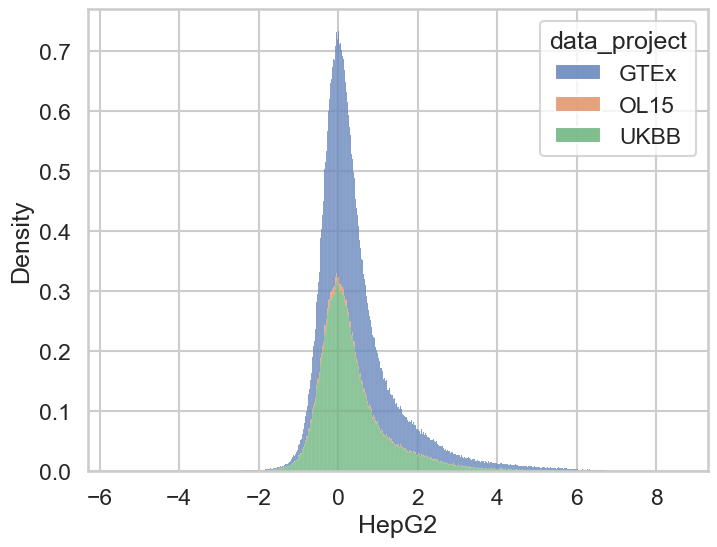

In [16]:
sns.histplot(my_processed_df, x='HepG2', stat='density', hue='data_project', multiple='stack')

In [17]:
my_processed_df[my_processed_df['seq'].isna()]

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116


In [18]:
my_processed_df[my_processed_df['seq'].duplicated(keep=False)]

,seq,ID,chr,pos,ref_allele,alt_allele,allele,OL,data_project,K562,HepG2,SK-N-SH,A549,HCT116


In [19]:
original_df = pd.read_csv('../data/GosaiMPRANature/GosaiMPRA.csv')
original_df

# original_df['long_ID'] = original_df['ID'].apply(lambda x: x.split(',')[-1])
# original_df['ID'] = original_df['long_ID'].map(get_core_id)
# original_df

/tmp/ipykernel_5567/2157691181.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv('../data/GosaiMPRANature/GosaiMPRA.csv')


,ID,chr,data_project,OL,K562,HepG2,SK-N-SH,seq
0,7:70038969:G:T:A:wC,chr7,UKBB,29,0.061,0.234,0.047,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...
1,1:192696196:C:T:A:wC,chr1,UKBB,33,0.380,0.005,-0.244,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...
2,1:211209457:C:T:A:wC,chr1,UKBB,33,0.037,0.385,-0.005,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...
3,15:89574440:GT:G:A:wC,chr15,UKBB,33,4.465,4.107,2.870,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...
4,15:89574440:GT:G:R:wC,chr15,UKBB,33,4.509,4.116,3.040,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...
...,...,...,...,...,...,...,...,...
798059,4:44680358:NA:NA,chr4,CRE,15,7.444,5.344,6.585,CAGTAGTAAGAAAGAGACAATGCAAAGGAATTGGCACAGCACTCAG...
798060,18:9125893:NA:NA,chr18,CRE,15,-0.205,-0.157,-0.209,CAGTACTGCTGGCCCCAGAAAAGCCCCTCTCCTTATACCCTAGGCC...
798061,12:33905808:NA:NA,chr12,CRE,15,1.218,0.614,0.570,CAGTACCTTGTCCCCACTTCCCATTTGGCCTCTGGCAGAGGAGGAG...
798062,3:128145854:NA:NA,chr3,CRE,15,-0.222,-0.339,-0.818,CAGTACACCCCAGCTTCCAAAGGCCTTCTGTGACAAAGAGAGACTA...


In [20]:
original_df['data_project'].value_counts()

data_project
GTEX    445580
UKBB    338398
CRE      14086
Name: count, dtype: int64

In [21]:
original_df[original_df['seq'].duplicated(keep=False)]

,ID,chr,data_project,OL,K562,HepG2,SK-N-SH,seq


In [22]:
original_df[original_df['ID'].duplicated(keep=False)]

,ID,chr,data_project,OL,K562,HepG2,SK-N-SH,seq
54562,19:54676763:C:T:R:wL:Alt_19-54676814-A,chr19,UKBB,32,0.019,0.702,-1.027,CTTCTCCTGGCATTCCCTACCTCCTCTGGCCTCCCGGGGGGCCAGC...
54564,19:54676763:C:T:A:wL:Alt_19-54676814-A,chr19,UKBB,32,0.007,0.518,-1.589,CTTCTCCTGGCATTCCCTACCTCCTCTGGCCTCCCGGGGGGCCAGC...
64731,19:54676763:C:T:A:wC:Alt_19-54676814-A,chr19,UKBB,32,0.118,0.572,0.028,CCTCCTCCAGCAGGACTCCCACCTAGCCTGAAGGTCGGATGGATCT...
64749,19:54676763:C:T:R:wC:Alt_19-54676814-A,chr19,UKBB,32,0.086,0.553,-0.242,CCTCCTCCAGCAGGACTCCCACCTAGCCTGAAGGTCGGATGGATCT...
651490,19:54676763:C:T:R:wC:Alt_19-54676814-A,chr19,GTEX,42,-0.386,0.630,-0.031,TCCTCCTCCAGCAGGACTCCCACCTAGCCTGAAGGTCGGATGGATC...
651491,19:54676763:C:T:A:wC:Alt_19-54676814-A,chr19,GTEX,42,-0.235,0.798,0.220,TCCTCCTCCAGCAGGACTCCCACCTAGCCTGAAGGTCGGATGGATC...
696845,19:54676763:C:T:A:wL:Alt_19-54676814-A,chr19,GTEX,42,0.371,1.033,-0.001,CTTCTCCTGGCATTCCCTACCTCCTCTGGCCTCCCGGGGGGCCAGC...
696852,19:54676763:C:T:R:wL:Alt_19-54676814-A,chr19,GTEX,42,0.097,0.995,-1.084,CTTCTCCTGGCATTCCCTACCTCCTCTGGCCTCCCGGGGGGCCAGC...


In [23]:
merged_df = pd.merge(original_df, my_processed_df, on='seq', how='outer')
merged_df

,ID_x,chr_x,data_project_x,OL_x,K562_x,HepG2_x,SK-N-SH_x,seq,ID_y,chr_y,pos,ref_allele,alt_allele,allele,OL_y,data_project_y,K562_y,HepG2_y,SK-N-SH_y,A549,HCT116
0,1:161114366:A:T:R:wC,chr1,GTEX,42,0.290,-0.062,0.013,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCTGGGTG...,1:161114366:A:T:R:wC,chr1,161114366.000,A,T,ref,OL41_42,GTEx,0.379,-0.049,-0.119,NaN,-0.291
1,1:161114366:A:T:A:wC,chr1,GTEX,42,0.415,-0.020,-1.257,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCTGGGTG...,1:161114366:A:T:A:wC,chr1,161114366.000,A,T,alt,OL41_42,GTEx,-0.401,0.215,-2.281,NaN,-0.329
2,7:89640175:A:G:A:wC,chr7,UKBB,29,0.956,0.293,-0.780,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGAATGTCAGTT...,7:89640175:A:G:A:wC,chr7,89640175.000,A,G,alt,OL29,UKBB,0.956,0.297,-0.801,1.360,NaN
3,19:9294737:G:A:A:wC,chr19,GTEX,42,-0.078,0.456,-0.075,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGACAAGAGTTGGCA...,19:9294737:G:A:A:wC,chr19,9294737.000,G,A,alt,OL41_42,GTEx,-0.101,0.468,-0.154,NaN,-0.168
4,19:9294737:G:A:R:wC,chr19,GTEX,42,0.135,0.397,0.128,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGACAAGAGTTGGCA...,19:9294737:G:A:R:wC,chr19,9294737.000,G,A,ref,OL41_42,GTEx,0.154,0.352,-0.016,NaN,0.116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798173,19:51495611:C:T:A:wC,chr19,GTEX,42,3.992,2.314,1.359,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCA...,19:51495611:C:T:A:wC,chr19,51495611.000,C,T,alt,OL41_42,GTEx,2.988,0.760,-0.777,NaN,1.527
798174,6:153341374:C:T:R:wC,chr6,GTEX,41,0.341,0.254,-0.055,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCG...,6:153341374:C:T:R:wC,chr6,153341374.000,C,T,ref,OL41_42,GTEx,0.291,-0.115,0.004,NaN,-0.402
798175,6:153341374:C:T:A:wC,chr6,GTEX,41,-0.156,0.364,-0.092,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAGAGTCTCG...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798176,2:181602082:C:T:R:wC,chr2,GTEX,42,2.206,2.024,1.885,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGTCTTG...,2:181602082:C:T:R:wC,chr2,181602082.000,C,T,ref,OL41_42,GTEx,2.276,2.067,1.982,NaN,2.346


In [24]:
merged_df[merged_df['chr_x'].isna() & merged_df['chr_y'].notna()]

,ID_x,chr_x,data_project_x,OL_x,K562_x,HepG2_x,SK-N-SH_x,seq,ID_y,chr_y,pos,ref_allele,alt_allele,allele,OL_y,data_project_y,K562_y,HepG2_y,SK-N-SH_y,A549,HCT116
14152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAACTTTGCACTTATCCTCCAAGCCCACGTGTGATCCGATTCTTCC...,12:19989440:C:A:A:wC:Alt_12-19989479-R,chr12,19989440.000,C,A,alt,OL31,UKBB,0.812,0.744,-0.519,1.314,NaN
18986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAAGTTCTTACTAAGGGATTCAACCAGTCAGCGTCCCCCCACCCCC...,3:128212963:T:C:R:wC,chr3,128212963.000,T,C,ref,OL28,UKBB,0.738,0.950,-0.824,-0.208,NaN
23926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAATTAGGTGGGCGTGGTGGTGGGCACCTGTAGTCTCAGCTACTCA...,17:60546622:C:A:A:wR:Alt_17-60546624-R,chr17,60546622.000,C,A,alt,OL30,UKBB,1.083,-2.653,-2.035,-0.219,NaN
33053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AACTCATATATATATATATATATATATATATATATATATATATATA...,7:86914154:C:T:A:wC,chr7,86914154.000,C,T,alt,OL29,UKBB,1.804,0.802,1.986,-0.927,NaN
64433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AATTTAATTCTTACTAATGGCTGTGTTTAACAACTGGATTACAAAA...,16:46749203:C:G:A:wC,chr16,46749203.000,C,G,alt,OL41_42,GTEx,-3.119,0.625,-0.704,NaN,1.406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTATTCGGCTCTCTGCCTCAGCAGTCTACGCTATCTGTTAGGGTCT...,11:103870637:T:TTGA:R:wL:Alt_11-103870621-A,chr11,103870637.000,T,TTGA,ref,OL31,UKBB,1.579,-0.069,1.697,-1.547,NaN
753273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTCGGCTCTCTGCCTCAGCAGTCTACGCTATCTTGTCTGTTAGGGT...,11:103870641:T:A:R:wL:Alt_11-103870638-R,chr11,103870641.000,T,A,ref,OL31,UKBB,1.549,-0.057,0.885,-0.099,NaN
754640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTCTCAGCTGTAGCGCGTCCACGGCTCCGGGCCGGTTCCTGGGCCC...,9:116139288:G:GCGGGGATCGCGCGGGC:R:wR:Alt_9-116...,chr9,116139288.000,G,GCGGGGATCGCGCGGGC,ref,OL41_42,GTEx,6.911,5.242,5.611,NaN,4.062
776280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTATCCAGTGCCAGGGAGGAACAACATAGTTAATTTTTTTCTAAC...,7:100804430:C:T:A:wC,chr7,100804430.000,C,T,alt,OL41_42,GTEx,-0.140,1.261,2.261,NaN,1.152


In [25]:
merged_df[merged_df['chr_x'].notna() & merged_df['chr_y'].isna()]

,ID_x,chr_x,data_project_x,OL_x,K562_x,HepG2_x,SK-N-SH_x,seq,ID_y,chr_y,pos,ref_allele,alt_allele,allele,OL_y,data_project_y,K562_y,HepG2_y,SK-N-SH_y,A549,HCT116
43,6:68775710:T:G:A:wC,chr6,GTEX,41,-0.341,0.368,-0.035,AAAAAAAAAAAAAAAAAAAAAAAAGATTTCATGGTATTTGGAATAT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,7:66798521:T:A:R:wC,chr7,GTEX,41,-0.663,1.077,-3.005,AAAAAAAAAAAAAAAAAAAAAAATTAAATTCCTAGCCAGGTCTTCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,10:24857785:G:A:R:wC,chr10,UKBB,31,2.171,2.282,1.340,AAAAAAAAAAAAAAAAAAAACTAAAAAAAAAAAAAAAAACGATTAA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
903,14:21694594:G:T:A:wC,chr14,UKBB,32,2.119,2.278,2.615,AAAAAAAAAAGAAAGAAAGAATAGTACCAGGGTAGCTGTTGACGAA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1167,22:50642526:C:T:A:wC,chr22,GTEX,41,0.571,-0.009,3.403,AAAAAAAAATTCAAAAATGGACAAGTATTTGAATAGACATTTCTTC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798159,15:50390579:C:T:A:wC,chr15,UKBB,27,0.083,1.083,0.716,TTTTTTTTTTTTTTTTTTTTTTTTTTTTAGATAGGGTCTCACTCTG...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798164,14:23406304:G:A:A:wC,chr14,GTEX,41,0.301,0.215,-0.365,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACACCTCTGCCTCT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798168,16:70391374:A:G:R:wC,chr16,GTEX,41,1.716,1.058,0.848,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACCAAGTCGTGC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798169,16:70391374:A:G:A:wC,chr16,GTEX,41,2.457,1.248,1.611,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACCAAGTCGTGC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for cell_type in ['HepG2', 'K562', 'SK-N-SH']:
    x = merged_df[f'{cell_type}_x']
    y = merged_df[f'{cell_type}_y']
    print(pearson(x, y))

(0.9983352690387901, 0.0)
(0.9982699412830638, 0.0)
(0.9982371407888242, 0.0)
